# A first segmentation

In the previous chapter we examined a single streamline.  In this chapter we will perform a "segmentation" of sorts, wherein we divide up the whole brain tractogram.  One of the challenges we experienced in the previous chapter was that the whole brain tractogram is unwieldy and impenetrable.  What we need is the ability to look at specific sub-components of the tractogram in order to systematically make insights about our model of the brain's white matter.  But how would we do this?  We can find the answer to this by reflecting on our earlier work with satellite images. 

### Making a tractogram tractable

**How could we systematically divide up the white matter?**

As we seek to make our tractogram more manageable we find ourselves in a position similar to the one we were in when considering the satellite images.  Although we have an intuitive understanding with the familiar geography depicted in the satellite image, we nonetheless needed to narrow our consideration of the available data in order to make good use of it.  In the satellite case we performed an ocean-based mask, and in the NiFTI case we used an existing parcellation.  But how would we do this with a whole brain tractogram?  

Perhaps we can leverage an analogy with the highway system of the United States. If we consider the various regions of the brain (e.g. the ones we find in a parcellation) to be like the states of the United States, and the white matter to be the roads and highways that connect them, an approach presents itself.  We could perform a systematc process of pairwise matching wherein, for each pairing of states, we identify those roads and highways (or streamlines) that start and/or finish in those areas. After all, both white matter tracts and roads have to begin and end somewhere.

To achieve our goal of tractogram sub-selection we can leverage the parcellation data we were looking at previously.  This data object assigns each voxel a label, and so we can--for each streamline--determine which labels its endpoints are closest to.  This will give us a mapping of streamlines which have ends in both regions A and B, A and C, C and B, and so on and so forth, for all possible pairings of labels.

To begin we'll need to load up a parcellation:

In [1]:
#this code ensures that we can navigate the WiMSE repo across multiple systems
import subprocess
import os
#get top directory path of the current git repository, under the presumption that 
#the notebook was launched from within the repo directory
gitRepoPath=subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('ascii').strip()

#move to the top of the directory
os.chdir(gitRepoPath)

import nibabel as nib
import numpy as np

atlasPath=os.path.join(gitRepoPath,'exampleData','parc.nii.gz')
#load it as an object
atlasImg = nib.load(atlasPath)
atlasData = atlasImg.get_fdata()
#set the print option so it isn't printing in scientific notation
np.set_printoptions(suppress=True)
#condense to unique values
uniqueAtlasEntries=np.unique(atlasData).astype(int)

import pandas as pd
FSTablePath=os.path.join(gitRepoPath,'exampleData','FreesurferLookup.csv')
#read table using pandas
FSTable=pd.read_csv(FSTablePath)
#create a boolean vector for the indexes which are in uniqueAtlasEntries
currentIndexesBool=FSTable['#No.'].isin(uniqueAtlasEntries)
#create new data frame with the relevant entries
currentParcellationEntries=FSTable.loc[currentIndexesBool]
#reset the indexes, whicj were disrupted by the previous operation
#currentParcellationEntries=currentParcellationEntries.reset_index(drop=True)
currentParcellationEntries.tail(20)

,#No.,LabelName:,R,G,B,A
1120,12156,ctx_rh_S_interm_prim-Jensen,141,60,20,0
1121,12157,ctx_rh_S_intrapariet_and_P_trans,143,20,220,0
1122,12158,ctx_rh_S_oc_middle_and_Lunatus,101,60,220,0
1123,12159,ctx_rh_S_oc_sup_and_transversal,21,20,140,0
1124,12160,ctx_rh_S_occipital_ant,61,20,180,0
1125,12161,ctx_rh_S_oc-temp_lat,221,140,20,0
1126,12162,ctx_rh_S_oc-temp_med_and_Lingual,141,100,220,0
1127,12163,ctx_rh_S_orbital_lateral,221,100,20,0
1128,12164,ctx_rh_S_orbital_med-olfact,181,200,20,0
1129,12165,ctx_rh_S_orbital-H_Shaped,101,20,20,0


Now that we have the parcellation loaded, we can load our whole brain tractogram and perform the iterative assignment of streamlines to atlas labels.  In this way, each streamline will be assigned two numbers corresponding to the label number closest to its first and last node.  This method is at the heart of the burgeoning field of [connectomics](https://en.wikipedia.org/wiki/Connectomics) (e.g. [Bullmore, E., Sporns, O., 2009](https://doi.org/10.1038/nrn2575), [Behrens, T. E., & Sporns, O., 2012](https://doi.org/10.1016/j.conb.2011.08.005)).  As such, it is not surprising that a great deal of research and ingenuity has been applied to developing optimized software and algorithms for this approach.  In fact, [dipy](https://dipy.org/) has a very straightforward function for this: _dipy.tracking.utils.connectivity_matrix_ . 

Lets apply [this method](https://dipy.org/documentation/1.0.0./examples_built/streamline_tools/) now and look at the outputs.  We'll also plot an interactive visualization of the parcellation that can help serve as a reference for these subdivisions.
(Note, this is a non-trivial set of computations, and so executing the next block will take a moment.  Be careful not to try and run it multiple times.)

In [2]:
# load the tractography file into the streamsObjIN variable
smallTractogramPath=os.path.join(gitRepoPath,'exampleData','smallTractogram.tck')
streamsObjIN=nib.streamlines.load(smallTractogramPath)

#because of how dipy does connectivity matrtricies, we have to relabel the atlas
remappingFrame=currentParcellationEntries.reset_index(drop=True)
#establish a copy
relabeledAtlas=atlasData.copy()
#iterate across unique label entries
for iLabels in range(len(remappingFrame)):
    #replace the current uniqueAtlasEntries value with the iLabels value
    #constitutes a simple renumbering schema
    relabeledAtlas[relabeledAtlas==uniqueAtlasEntries[iLabels]]=iLabels

from dipy.tracking import utils
#segment tractome into connectivity matrix from parcellation
M, grouping=utils.connectivity_matrix(streamsObjIN.tractogram.streamlines, atlasImg.affine, label_volume=relabeledAtlas.astype(int),
                        return_mapping=True,
                        mapping_as_streamlines=False)

Now that we have performed that lengthy segmentation, let's take a quantitative look at how many streamlines are connecting each region.  We'll first do this using the standard method of [connectomics](https://en.wikipedia.org/wiki/Connectomics), a connectivity matrix.  In the brain connectivity matrix plot, each row/column corresponds to a brain area in a given parcellation.  Each entry (i.e. row X, column Y; or edge measure) is associated with a particular measure, which is visually depicted by a color from a colormap, which reflects some measure of connectivity between those brain areas.  In the matrix we will plot below, that color value will correspond to the number of streamlines connecting those areas.

As a warning, these plots are somewhat difficult to comprehend in that it is difficult to associate particular areas with a trend or insight.  Typically these plots are used to depict and infer general patterns in the overall connectivity arrangement of the brain.

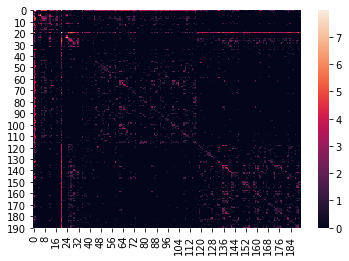

In [4]:
import seaborn as sns
sns.heatmap(np.log1p(M))

Here we'll also present the dataframe containing the remapped numberings (in the index column) to reference with the above figure.  Remember in the matrix plot, each row (and column) corresponds to a specific label in the parcellation.  Due to the renumbering we performed, the index column of the below table indicates which anatomical label is associated with which entry of the above matrix figure.

In [5]:
import itables
resetTable=remappingFrame.reset_index()
itables.show(resetTable,paging=True)

<IPython.core.display.Javascript object>

index,#No.,LabelName:,R,G,B,A


In order to make the information in the matrix a bit more digestible, we can look at the information contained in each row/column as a bar graph.  Below we'll do this in an interactive fashion.  Be warned:  some rows have only a few connections and are fairly straightforward to view in this way, while others may have a large number of connections and may result in a particularly large bar plot.

In [6]:

dropDownList=list(zip(currentParcellationEntries['LabelName:'].to_list(), currentParcellationEntries['#No.'].to_list()))

def plotCurrentLabelCounts(currLabel):
    import seaborn as sns
    from itertools import compress
    import matplotlib.pyplot as plt
    #convert the input FS Label number to the renumbered index
    currentRenumberIndex=resetTable['index'].loc[resetTable['#No.']==currLabel].values[0]    
    if currentRenumberIndex in np.asarray(list(grouping.keys())): 
        #get name to label plot
        currentInputName=currentParcellationEntries['LabelName:'].loc[currentParcellationEntries['#No.']==currLabel].values[0]
        #turn the gouping keys (pairs of integers) into a dataframe
        allKeysFrame=pd.DataFrame.from_dict(grouping.keys())
        #extract from the keyList (of all pairings), a boolean vector corresponding those pairings where either value is the current label of interest
        currentBool=np.logical_or(allKeysFrame[0]==currentRenumberIndex,allKeysFrame[1]==currentRenumberIndex)
        #because the values are lists of streamline indexes, we can get the lenght of these lists to count the number of streamlines 
        streamCounts = [len(v) for v in grouping.values()]
        #extract those index pairs via the boolean vector
        currentPairs=allKeysFrame[currentBool].to_numpy()
        #very janky method for obtaining current label of interest
        #works because these are integers.  Can't currently think of an edge case for this.
        currentLabelNums=np.sum(currentPairs,axis=1)-currentRenumberIndex
        #get the names of the labels corresponding to the non currLabel labels 
        currentLabelNames=resetTable['LabelName:'].loc[currentLabelNums]
        #extract the counts from the total counts list
        currentCounts=list(compress(streamCounts,currentBool.values))
        #create the data for a dataframe
        currentFrameData={'labelNo':currentLabelNums,'LabelName':currentLabelNames.values,'streamCount':currentCounts}
        #convert that into a dataframe
        currentFrame=pd.DataFrame(currentFrameData)
        #adaptively set dimensions
        plotDim1=len(currentLabelNames)*.3
        plt.figure(figsize=(5,plotDim1))
        #plot it
        ax = sns.barplot(y="LabelName", x="streamCount", data=currentFrameData)
        #set logscale
        ax.set_xscale("log")
        ax.set(title="streamline connections to " + currentInputName, xlabel='log scale streamline count', ylabel='freesurfer label')
     
    else: 
        print('connections not present')
        
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Dropdown

#establish interactivity
interact(plotCurrentLabelCounts, 
         currLabel=Dropdown(options=dropDownList, value=2, description="region1"), 
        )

interactive(children=(Dropdown(description='region1', index=1, options=(('Unknown', 0), ('Left-Cerebral-White-…

<function __main__.plotCurrentLabelCounts(currLabel)>

Also, to help us remember the actual reference brain parcellation we'll plot the parcellaton in an interactive fashion below.

In [7]:
from niwidgets import NiftiWidget

renumberedAtlasNifti=nib.Nifti1Image(relabeledAtlas, atlasImg.affine, atlasImg.header)  

atlas_widget = NiftiWidget(renumberedAtlasNifti)
atlas_widget.nifti_plotter(colormap='nipy_spectral')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=127, continuous_update=False, description='x', max=255), IntSlider(value…

Finally, let's allow ourselves to interact with streamlines connecting particular pairs of labels.  In the widget below you'll be able to select two labels from the FreeSurfer parcellation.  In some cases, the widget will inform you that there are no streamlines that connect those regions.  In other cases you'll be able to interact with the visualization for that collection of streamlines.  

**Be sure to zoom in, as the visualization tends to start from a distant position.**

In [8]:
#get tractogram from the Tck holder
sourceTractogram=streamsObjIN.tractogram

#quick and dirty tractogram subsetter by Brad Caron
#https://github.com/bacaron
def extractSubTractogram(sourceTractogram,indexes):
    #import relevant package
    import nibabel as nib
    #extrect the desired streamlines into a new streamline object
    streamlines = sourceTractogram.streamlines[indexes]
    #establish tractogram object
    out_tractogram = nib.streamlines.tractogram.Tractogram(streamlines)
    #adjust the relevant header fields
    #don't bother for now, header is only relevant to Tck file
    #for headerFields in ['total_count','count','nb_streamlines']:
        #nb_streamlines is an int, whereas the others are strings, for some reason
    #    if headerFields == 'nb_streamlines':
    #        out_tractogram.header[headerFields] = len(streamlines)
    #    else:
    #        out_tractogram.header[headerFields] = '%s' %len(streamlines)
    return out_tractogram

#interactive plotting via niwidgets?  
#widget within a widget doesn't seem to work
def plotParcellationConnectionWidget(subTractogram):
    #import widget
    from niwidgets import StreamlineWidget
    #set widget object
    
    sw = StreamlineWidget(streamlines=subTractogram)
    #set plotting characteristics
    style = {'axes': {'color': 'red',
                  'label': {'color': 'white'},
                  'ticklabel': {'color': 'white'},
                  'visible': False},
         'background-color': 'black',
         'box': {'visible': False}}
    #plot it
    sw.plot(display_fraction=1, width=1000, height=1000, style=style, percentile=0)

def plotTract(tractIn):
    import numpy as np
    from dipy.viz import window, actor
    renderer = window.Scene()
    stream_actor = actor.line(tractIn)
    #renderer.set_camera(position=(-176.42, 118.52, 128.20),
    #               focal_point=(113.30, 128.31, 76.56),
    #                view_up=(0.18, 0.00, 0.98))
    %matplotlib inline
    renderer.add(stream_actor)
    
    window.show(renderer, size=(600, 600), reset_camera=True)

def updateFunction(regionIndex1,regionIndex2):
    currentRenumberIndex1=resetTable['index'].loc[resetTable['#No.']==regionIndex1].values[0]    
    currentRenumberIndex2=resetTable['index'].loc[resetTable['#No.']==regionIndex2].values[0]    
 
    
    #check to make sure this pairing is actually in the connections
    if (currentRenumberIndex1,currentRenumberIndex2) in grouping.keys(): 
        currentIndexes=grouping[currentRenumberIndex1,currentRenumberIndex2]
        subTractogram=extractSubTractogram(sourceTractogram,currentIndexes)
        %matplotlib inline
        plotParcellationConnectionWidget(subTractogram.streamlines)
    else:
        print('connection not present')

dropDownList=list(zip(currentParcellationEntries['LabelName:'].to_list(), currentParcellationEntries['#No.'].to_list()))

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Dropdown

#establish interactivity
interact(updateFunction, 
         regionIndex1=Dropdown(options=dropDownList, value=2, description="region1"), 
         regionIndex2=Dropdown(options=dropDownList, value=2, description="region2"),
        )

interactive(children=(Dropdown(description='region1', index=1, options=(('Unknown', 0), ('Left-Cerebral-White-…

<function __main__.updateFunction(regionIndex1, regionIndex2)>

In the above figures and widgets we have depicted the source parcellation, and the resulting map of which streamlines connect to which areas in that parcellations.  There are a few overarching things we ought to note about this:

- All streamlines are assigned:  There are no streamlines that are not associated with 2 labels (one per endpoint).
- "Accurate" labeling of streamlines is **hugely** dependent on the streamline tractogram being appropriately aligned with the parcellation.  If there is a misalignment (i.e. a flip, or a translation on a particular dimension) the labels attributed to streamlines may not be at all appropriate.
- Given that a streamline is supposed to represent a collection of axons, a streamline must also subject to many of the same constraints that axons are.  Prime among these is that the streamline be **biologically plausible**.  This means that, among other things, it must terminate in reasonable areas and follow a sensible path as it traverses the brain.

Let's explore this notion of **biological plausibility** in the next chapter, as it is key to a preliminary thresholding/cleaning of our tractography which permits subsequent, anatomically guided segmentations.